In [1]:
##### Data and libraries

# Common libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns

# Chapter-specific libraries
import statsmodels.stats.outliers_influence as st_inf # For Cook's distance
import matplotlib.pyplot as plt
import statsmodels.api as sm # For QQ plot

### Generating the data

times = [2,2,3,5,6,9,10,47,61,413]
experience = [11,17,18,1,10,4,6,3,8,0]

data_df = pd.DataFrame(
    {'times': times, 
    'experience': experience})

In [3]:
#  calculating upper and lower confidence intervals for sample mean
lin_mod = ols("times~1", data=data_df).fit()
est = lin_mod.params['Intercept']
se = lin_mod.bse['Intercept']
LL = est-1.96*se
UL = est+1.96*se
print(f'Lower Limit: {LL}\nUpper Limit: {UL}')

Lower Limit: -23.040199740431348
Upper Limit: 134.64019974043134


In [6]:
boot_df = data_df.sample(len(data_df), replace=True) # sampling dataset with replacement
boot_df

,times,experience
9,413,0
9,413,0
2,3,18
3,5,1
0,2,11
0,2,11
1,2,17
8,61,8
8,61,8
8,61,8


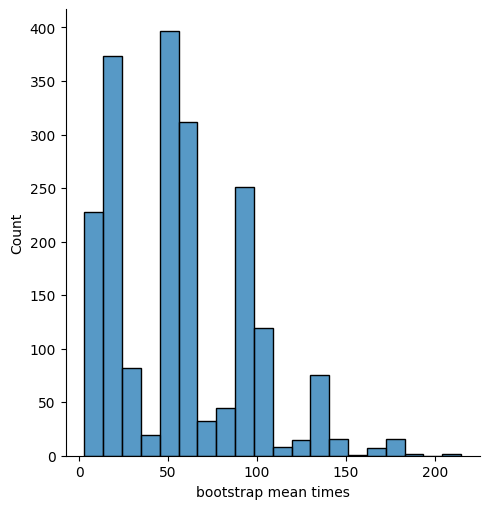

In [20]:
%matplotlib inline
res_boot_sim = []
B = 2000
N = len(data_df)
for i in range(B):
    boot_df = data_df.sample(N, replace=True)
    M = np.mean(boot_df.times)
    res_boot_sim.append(M)

g = sns.displot(res_boot_sim, kind='hist')
g.set_axis_labels('bootstrap mean times')

In [22]:
# constructing CI from bootstrap
# values will vary across resamples as they are randomly generated
LL_b = np.quantile(res_boot_sim, 0.025)
UL_b = np.quantile(res_boot_sim, .975)
print(f"Lower Limit Boostrap: {LL_b}\nUpper Limit Bootstrap: {UL_b}")

Lower Limit Boostrap: 7.387500000000001
Upper Limit Bootstrap: 138.92749999999987
